In [1]:
import matplotlib
matplotlib.rcParams['font.size'] = 24
matplotlib.rcParams.update({
    "font.family": "serif",
})
import matplotlib.pyplot as plt

In [2]:
import glob
import numpy as np
import pandas as pd

from pymatgen.analysis.phase_diagram import PDEntry, PhaseDiagram
from pymatgen.core import Composition, Element, Structure
from pymatgen.io.lammps.data import LammpsData
from pymatgen.io.lammps.outputs import parse_lammps_dumps
from pymatgen.analysis.diffusion_analyzer import get_conversion_factor
from pymatgen.io.lammps.outputs import parse_lammps_log
import scipy.constants as const

/opt/conda/lib/python3.9/site-packages/pymatgen/analysis/diffusion_analyzer.py:44: FutureWarning: All code in pymatgen.analysis.diffusion_analyzer has been moved to the separate add-on packagepymatgen-diffusion, which also includes a lot more functionality for analyzing diffusioncalculations. This module here is retained for backwards compatibility. It will be removed from2022.1.1.
  warnings.warn(


In [3]:
import plotly
import plotly.express as px
import plotly.figure_factory as ff
import numpy as np
import seaborn as sns

In [4]:
t_steps = np.linspace(0, 10**3, 5001)

In [5]:
def fit_msd(data):
    start = 100
    end = 1000
    n = data.shape[0]
    k, b = np.polyfit(np.linspace(0, 0.2*(n-1), n)[start:end], data[start:end], 1)
    return k, b

# NpT lattice parameters

In [6]:
dumpfiles = glob.glob('LiGePS/expansion-coefs/*/dump.*')

pbedf = pd.DataFrame([{
    'vol': np.array([conf.box.to_lattice().volume for conf in parse_lammps_dumps(dumpfile)]).mean()/18,
    'a': np.array([conf.box.to_lattice().a for conf in parse_lammps_dumps(dumpfile)]).mean()/3,
    'c': np.array([conf.box.to_lattice().c for conf in parse_lammps_dumps(dumpfile)]).mean()/2,
    'temperature': int(dumpfile.split('/')[2]), 
} for dumpfile in dumpfiles])

pbedf = pbedf.sort_values('temperature')

In [7]:
dumpfiles = glob.glob('LiGePS/expansion-coefs-pbesol/*/dump.*')

pbesoldf = pd.DataFrame([{
    'vol': np.array([conf.box.to_lattice().volume for conf in parse_lammps_dumps(dumpfile)]).mean()/18,
    'a': np.array([conf.box.to_lattice().a for conf in parse_lammps_dumps(dumpfile)]).mean()/3,
    'c': np.array([conf.box.to_lattice().c for conf in parse_lammps_dumps(dumpfile)]).mean()/2,
    'temperature': int(dumpfile.split('/')[2]), 
} for dumpfile in dumpfiles])

pbesoldf = pbesoldf.sort_values('temperature')

In [8]:
expA = pd.read_csv('a.csv')
expC = pd.read_csv('c.csv')

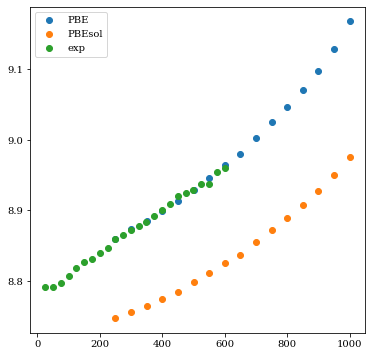

In [9]:
plt.figure(figsize=[6, 6])
plt.scatter(pbedf['temperature'], pbedf['a'], label='PBE')
plt.scatter(pbesoldf['temperature'], pbesoldf['a'], label='PBEsol')
plt.scatter(expA['x'], expA['Curve1'], label='exp')
plt.legend()

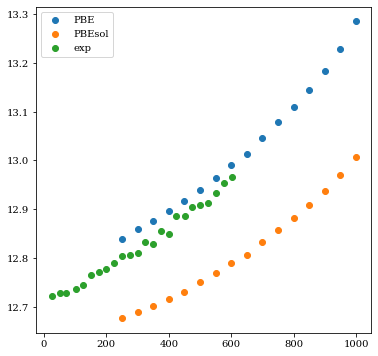

In [10]:
plt.figure(figsize=[6, 6])
plt.scatter(pbedf['temperature'], pbedf['c'], label='PBE')
plt.scatter(pbesoldf['temperature'], pbesoldf['c'], label='PBEsol')
plt.scatter(expC['x'], expC['Curve1'], label='exp')
plt.legend()

thermal expansion coefficient: 3.177376130204915e-05


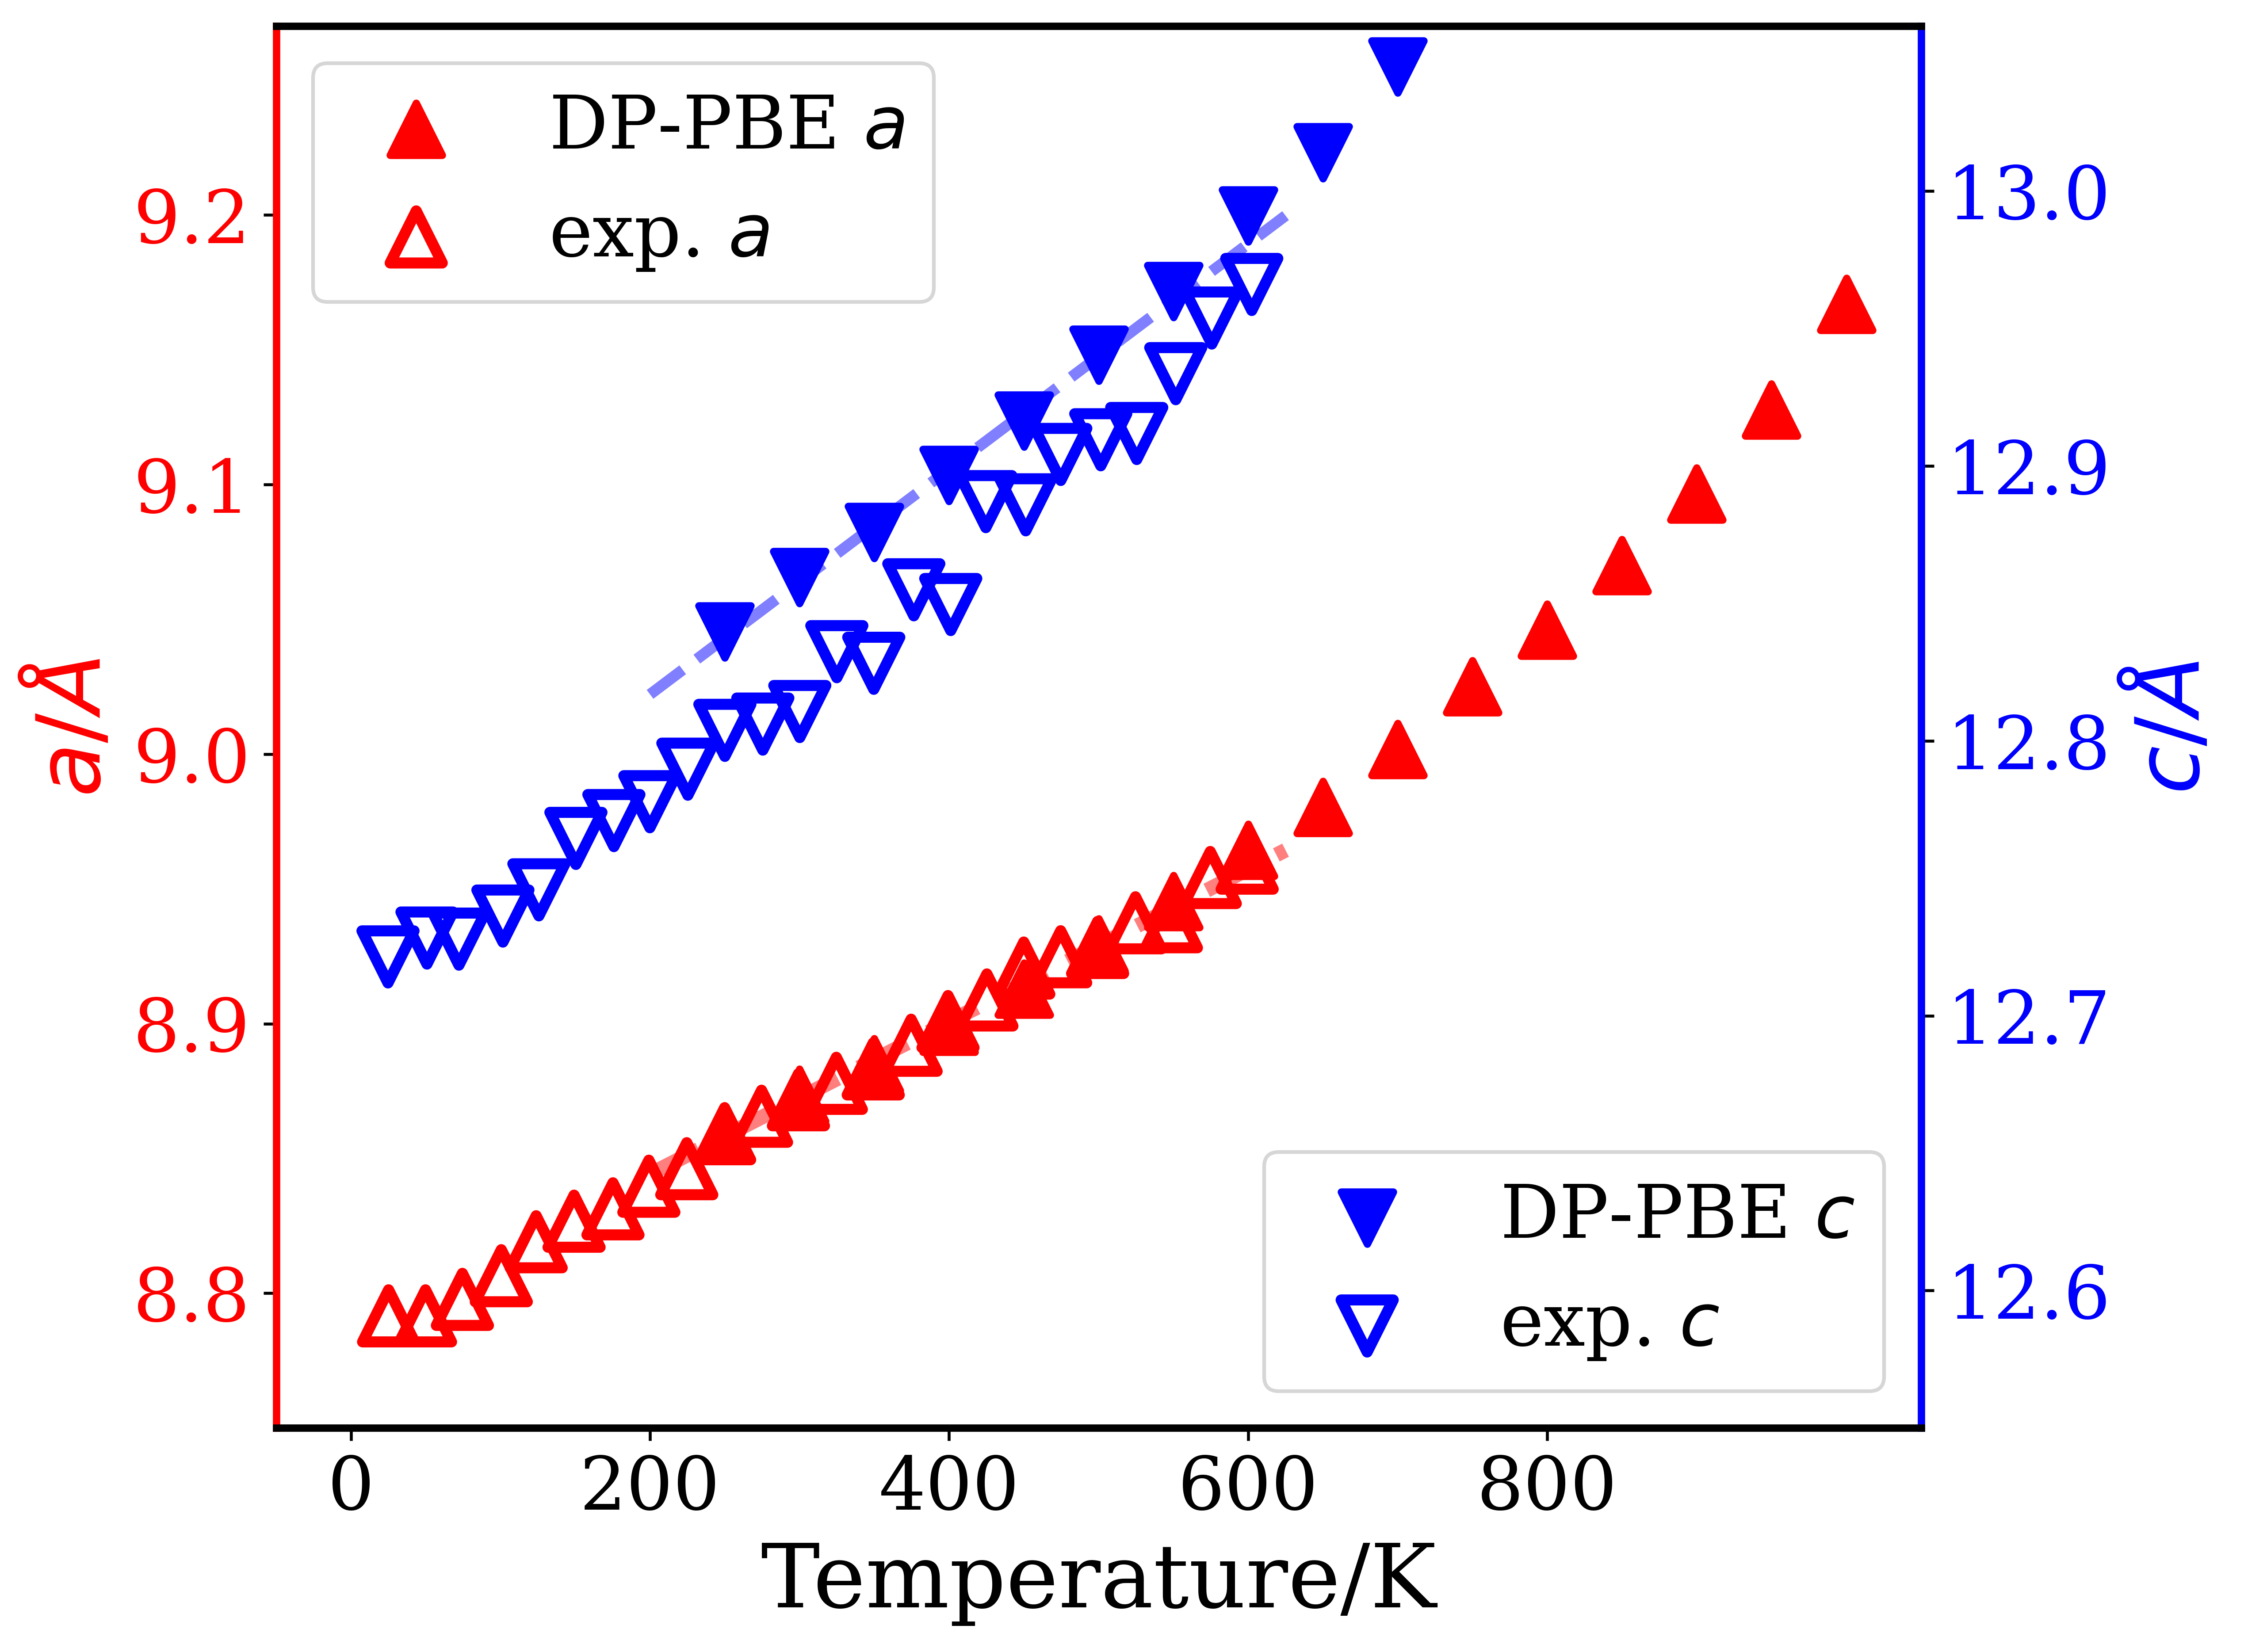

In [11]:
fig = plt.figure(figsize=[8, 7], dpi=600) #dpi=600

ax = fig.add_subplot(111)
#plt.text(50, 9.25, 'a)', fontsize=36)
plt.xticks([0, 200, 400, 600, 800], fontsize=20)
plt.yticks([8.8, 8.9, 9.0, 9.1, 9.2], fontsize=20, color='red')

st11 = ax.scatter(pbedf['temperature'], pbedf['a'], label='DP-PBE $a$', 
            marker='^', facecolor='red', edgecolors='red', s=200, linewidths=2)
k, b = np.polyfit(pbedf['temperature'][:-9], pbedf['a'][:-9], 1 )
l1 = ax.plot([200, 625], k*np.array([200, 625])+b, linestyle='--', linewidth=4, color='red', alpha=0.5)
print(f"thermal expansion coefficient: {k/8.9}")
st12 = ax.scatter(expA['x'], expA['Curve1'],label='exp. $a$', 
            marker='^', facecolor='none', edgecolors='red', s=200, linewidths=3)
ta = k/np.average(pbedf['a'][1:3])


ax2 = ax.twinx()
plt.yticks([12.6, 12.7, 12.8, 12.9, 13.0], fontsize=20, color='blue')

st21 = ax2.scatter(pbedf['temperature'], pbedf['c'], label='DP-PBE $c$', 
           marker='v', facecolor='blue', edgecolors='blue', s=200, linewidths=2)
k, b = np.polyfit(pbedf['temperature'][:-9], pbedf['c'][:-9], 1 )
tc = k/np.average(pbedf['c'][1:3])

st22 = ax2.scatter(expC['x'], expC['Curve1'], label='exp. $c$',
            marker='v', facecolor='none', edgecolors='blue', s=200, linewidths=3)
l2 = ax2.plot([200, 625], k*np.array([200, 625])+b, linestyle='--', linewidth=3, color='blue', alpha=0.5)

#ax.grid()
ax.set_xlabel('Temperature/K', fontsize=24)
ax.set_ylabel('$a / Å$', fontsize=24, color='red')
ax2.set_ylabel('$c / Å$', fontsize=24, color='blue')
ax2.set_ylim(12.55, 13.06)
ax.set_ylim(8.75, 9.27)
ax.set_xlim(-50, 1050)

sts = [st11, st12, st21, st22]
labs = [l.get_label() for l in sts]

ax.legend(sts[:2], labs[:2], loc=2, fontsize=20)
ax2.legend(sts[2:], labs[2:], loc=4, fontsize=20)


ax = plt.gca()
lw = 2
ax.spines['bottom'].set_linewidth(lw)
ax.spines['left'].set_linewidth(lw)
ax.spines['top'].set_linewidth(lw)
ax.spines['right'].set_linewidth(lw)
ax.spines['left'].set_color('red')
ax.spines['right'].set_color('blue')